## import

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F

from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import torchvision.models as models_lib
import resnet_cifar10
import torch.backends.cudnn as cudnn
from torchvision.transforms import functional as vF
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt
from typing import Any, Callable, Optional, Tuple
import numpy as np

import pickle
import numpy as np
import cv2
import torch
import torchvision
from PIL import Image
import os 
import copy
import torch
import torchvision
import torch.nn as nn
import scipy
import torchvision.transforms as transforms
from torchvision import datasets as ds
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random

from PIL import Image
import cv2
import matplotlib.pyplot as plt

import torchvision.models as models_lib
from sklearn.decomposition import PCA
import pandas as pd

## hyper para

In [3]:
#reverse para
noise_mu = 3

batch_size = 128
learning_rate = 0.0005

## model arch

In [4]:
# net = models_lib.vgg16(pretrained=False, progress=False, num_classes=10)
# net._modules['avgpool'] = torch.nn.AdaptiveAvgPool2d(output_size = (1,1))
# net._modules['classifier'][0] = torch.nn.Linear(in_features=512, out_features=512, bias=True)
# net._modules['classifier'][3] = torch.nn.Linear(in_features=512, out_features=512, bias=True)
# net._modules['classifier'][6] = torch.nn.Linear(in_features=512, out_features=10, bias=True)



cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

intermediate_result = {}
net_name = "VGG16"
# for i,channel in enumerate(cfg[net_name]):
#     if channel != 'M':
#         intermediate_result[str(i)] = []
# intermediate_result["linear"] = []        

class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)
        global intermediate_result

    def forward(self, x):
        seq = self.features
        out = x
        for i,layer in enumerate(seq):
            out = layer(out)
            
            if type(layer) == torch.nn.modules.conv.Conv2d:
                intermediate_result[str(i)] = out
#         out = self.features(x)
        out = out.view(out.size(0), -1)
        intermediate_result["linear"] = out
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)



        
    

net = VGG(net_name)
# print(net)

# 定义损失函数和优化器
criterion = torch.nn.CrossEntropyLoss()

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

# 如果有gpu就使用gpu，否则使用cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## Reverse technique

In [5]:
class Oneone(torch.nn.Module):
    def __init__(self, inplace=False):
        super().__init__()
        self.inplace = inplace

    def forward(self, tensor):
        return tensor*2.0-1.0
        # return F.normalize(tensor, self.mean, self.std, self.inplace)

# transform = transforms.Compose是把一系列图片操作组合起来，比如减去像素均值等。
# DataLoader读入的数据类型是PIL.Image
# 这里对图片不做任何处理，仅仅是把PIL.Image转换为torch.FloatTensor，从而可以被pytorch计算
transform_train = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        Oneone(),
    ]
)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    Oneone(),
])
class AttackCIFAR10(CIFAR10):
    def __init__(
            self,
            root: str,
            train: bool = True,
            transform: Optional[Callable] = None,
            target_transform: Optional[Callable] = None,
            download: bool = False,
            source_label: int = None,
            target_label: int = None,
            max_num: int = None,
    ) -> None:
        super(AttackCIFAR10, self).__init__(root, train=train, transform=transform,
                                            target_transform=target_transform,
                                            download=download)
        self.all_data = None
        self.all_targets = None
        if source_label is not None:
            self._select(source_label, max_num)
            self.targets[:] = target_label

    def _select(self, label, max_num=None):
        if self.all_data is None:
            self.all_data = self.data.copy()
            self.all_targets = self.targets.copy()
        else:
            self.data = self.all_data.copy()
            self.targets = self.all_targets.copy()

        np_targets = np.asarray(self.targets)
        lb_index = (np_targets == label)
        assert np.sum(lb_index) > 0, "No data with label %d" % label

        self.targets = np_targets[lb_index]
        self.data = self.data[lb_index]

        if max_num is not None:
            n = len(self.data)
            sl_index = np.random.permutation(n)[:max_num]
            self.targets = np_targets[sl_index]
            self.data = self.data[sl_index]


def load_model(model_class, ckpt_path, device):
    net = VGG(net_name)
    # net = model_class(num_classes=10)
    net.to(device)
    if device == 'cuda':
#         net = torch.nn.DataParallel(net)
        cudnn.benchmark = True
    # Load checkpoint.
    checkpoint = torch.load(ckpt_path)
    net.load_state_dict(checkpoint['model_state_dict'])
#     best_acc = checkpoint['acc']
#     start_epoch = checkpoint['epoch']

#     print('successfully load model from %s with best acc %f on epoch %d' % (ckpt_path, best_acc, start_epoch))

#     return net, best_acc, start_epoch
    return net

inputs_mean = [0.4914, 0.4822, 0.4465]
inputs_std = [0.2023, 0.1994, 0.2010]


def test_acc(model_path):
    print('==> Preparing data..')
#     transform_train = transforms.Compose([
#         # transforms.RandomCrop(32, padding=4),
#         # transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize(inputs_mean, inputs_std),
#     ])
    trainset = CIFAR10(
        root='./data', train=True, download=True,
        transform=transform_train, )
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # net, _, _ = load_model(models_lib.resnet18, model_path, device)
    net, _, _ = load_model(resnet_cifar10.ResNet18, model_path, device)

    crt, tot = 0, 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = net(inputs)
        preds = torch.argmax(outputs, axis=1)
        crt += torch.sum(preds == targets)
        tot += len(preds)
    print('acc :', crt / tot *100)


def train(source_label, target_label, max_epoch, model_path, max_training_samples=None):
    print('==> Preparing data..')
#     transform_train = transforms.Compose([
#         # transforms.RandomCrop(32, padding=4),
#         # transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize(inputs_mean, inputs_std),
#     ])
    trainset = AttackCIFAR10(
        root='./data', train=True, download=True,
        transform=transform_train,
        source_label=source_label, target_label=target_label,
        max_num=max_training_samples)
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=False)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # net, _, _ = load_model(models_lib.resnet18, model_path, device)
#     net, _, _ = load_model(resnet_cifar10.ResNet18, model_path, device)
    net = load_model(resnet_cifar10.ResNet18, model_path, device)
    net.eval()

    eps = 1e-6
    inputs_std_tensor = torch.as_tensor(inputs_std, dtype=torch.float32, device=device)
    inputs_mean_tensor = torch.as_tensor(inputs_mean, dtype=torch.float32, device=device)
    inputs_std_tensor = inputs_std_tensor.view(-1, 1, 1)
    inputs_mean_tensor = inputs_mean_tensor.view(-1, 1, 1)

    mask_tanh = np.ones([1, 32, 32], dtype=np.float32) * -4
    # pattern_tanh = np.zeros([3, 32, 32], dtype=np.float32)
    pattern_tanh = np.random.rand(3, 32, 32).astype(np.float32) / 8 - (1 / 8 / 2)
    mask_tanh_tensor = Variable(torch.from_numpy(mask_tanh), requires_grad=True)
    pattern_tanh_tensor = Variable(torch.from_numpy(pattern_tanh), requires_grad=True)
    opt = torch.optim.Adam([pattern_tanh_tensor, mask_tanh_tensor], lr=0.1, betas=(0.5, 0.9))
#     opt = torch.optim.Adamax([pattern_tanh_tensor, mask_tanh_tensor], lr=0.1, betas=(0.5, 0.999))
#     opt = torch.optim.AdamW([pattern_tanh_tensor, mask_tanh_tensor], lr=0.1, betas=(0.5, 0.999))
#     opt = torch.optim.Adagrad([pattern_tanh_tensor, mask_tanh_tensor], lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0)
#     opt = torch.optim.Adadelta([pattern_tanh_tensor, mask_tanh_tensor], lr=2, rho=0.9, eps=1e-06, weight_decay=0)
#     opt = torch.optim.LBFGS([pattern_tanh_tensor, mask_tanh_tensor], lr=1, max_iter=100, max_eval=None, tolerance_grad=1e-05, tolerance_change=1e-09, history_size=100, line_search_fn=None)
    
#     opt = torch.optim.ASGD([pattern_tanh_tensor, mask_tanh_tensor], lr=0.01, lambd=0.0001, alpha=0.75, t0=1000000.0, weight_decay=0)
#     opt = torch.optim.SGD([pattern_tanh_tensor, mask_tanh_tensor], lr=1)
    
    tlab = np.zeros([1, 10], dtype=np.int32)
    tlab[0, target_label] = 1
    tlab_tensor = torch.from_numpy(tlab).to(device)

    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(net.parameters(), lr=0.1,
    #                       momentum=0.9, weight_decay=5e-4)
    for epoch in range(max_epoch):
        print('epoch %d' % epoch)
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(device), targets.to(device)

            opt.zero_grad()

            inputs = inputs * inputs_std_tensor + inputs_mean_tensor

            mask_tanh_tensor_dev = mask_tanh_tensor.to(device)
            pattern_tanh_tensor_dev = pattern_tanh_tensor.to(device)
            mask_tensor_dev = torch.tanh(mask_tanh_tensor_dev) / 2 + 0.5
            pattern_tensor_dev = torch.tanh(pattern_tanh_tensor_dev) / 2 + 0.5

            att_inputs = (1 - mask_tensor_dev) * inputs + mask_tensor_dev * pattern_tensor_dev
            att_inputs = vF.normalize(att_inputs, inputs_mean, inputs_std)
            outputs = net(att_inputs)

            '''
            probs = torch.softmax(outputs, axis=-1)
            real = torch.sum(tlab_tensor * probs, dim=1)
            other, _ = torch.max((1 - tlab_tensor) * probs - tlab_tensor * 10000, dim=1)
            at_loss = torch.mean(F.relu(other - real + 0.5))
            at_data = at_loss.data
            l1_loss = torch.sum(mask_tensor_dev)
            loss = at_loss + 1e-3 * (0.001 / (at_data+1e-6)) * F.relu(l1_loss-10)
            print(loss.item(), at_loss.item(), l1_loss.item())
            # '''

            # '''
            ce_loss = criterion(outputs, targets)
            ce_data = ce_loss.data
            l1_loss = torch.sum(mask_tensor_dev)
            loss = ce_loss + 1e-3 * (0.1 / ce_data) * F.relu(l1_loss - 10)
            print(loss.item(), ce_loss.item(), l1_loss.item())
            # loss = ce_loss
            # print(loss.item())
            # '''
            loss.backward()
            opt.step()

    mask_img = torch.tanh(mask_tanh_tensor) / 2 + 0.5
    pattern_img = torch.tanh(pattern_tanh_tensor) / 2 + 0.5
    merge_img = mask_img * pattern_img

    rst_dict = {'mask': mask_img.detach().cpu().numpy(),
                'pattern': pattern_img.detach().cpu().numpy()}
    with open('trigger_pattern.pkl', 'wb') as f:
        pickle.dump(rst_dict, f)

    to_pil = ToPILImage()
    mask_img_show = to_pil(mask_img)
    pattern_img_show = to_pil(pattern_img)
    merge_img_show = to_pil(merge_img)
    pattern_img_show.save('pattern.png')
    mask_img_show.save('mask.png')
    merge_img_show.save('merge.png')

    return mask_img, pattern_img


def test(mask_tensor, pattern_tensor, source_label, target_label, model_path):
    print('==> Preparing data..')
#     transform_train = transforms.Compose([
#         # transforms.RandomCrop(32, padding=4),
#         # transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize(inputs_mean, inputs_std),
#     ])
    testset = AttackCIFAR10(
        root='./data', train=False, download=True, transform=transform_train, source_label=source_label,
        target_label=target_label)
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=True)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # net, _, _ = load_model(models_lib.resnet18, model_path, device)
#     net, _, _ = load_model(resnet_cifar10.ResNet18, model_path, device)
    net = load_model(resnet_cifar10.ResNet18, model_path, device)

    net.eval()

    inputs_std_tensor = torch.as_tensor(inputs_std, dtype=torch.float32, device=device)
    inputs_mean_tensor = torch.as_tensor(inputs_mean, dtype=torch.float32, device=device)
    inputs_std_tensor = inputs_std_tensor.view(-1, 1, 1)
    inputs_mean_tensor = inputs_mean_tensor.view(-1, 1, 1)

    # mask_tensor = torch.from_numpy(mask).to(device)
    # pattern_tensor = torch.from_numpy(pattern).to(device)
    mask_tensor = mask_tensor.to(device)
    pattern_tensor = pattern_tensor.to(device)

    tot, crt = 0, 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)

        inputs = inputs * inputs_std_tensor + inputs_mean_tensor

        att_inputs = (1 - mask_tensor) * inputs + mask_tensor * pattern_tensor
        att_inputs = vF.normalize(att_inputs, inputs_mean, inputs_std)

        outputs = net(att_inputs)
        logits = outputs.detach().cpu().numpy()
        preds = np.argmax(logits, axis=-1)

        tot += len(preds)
        crt += np.sum(preds == target_label)

    print('test acc: %.2f%%' % (crt / tot * 100))
    return crt / tot * 100

def new_test(mask_tensor, pattern_tensor, source_label, target_label, net):
    print('==> Preparing data..')
#     transform_train = transforms.Compose([
#         # transforms.RandomCrop(32, padding=4),
#         # transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize(inputs_mean, inputs_std),
#     ])
    testset = AttackCIFAR10(
        root='./data', train=True, download=True, transform=transform_train, source_label=source_label,
        target_label=target_label,max_num=10000)
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=True)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # net, _, _ = load_model(models_lib.resnet18, model_path, device)
#     net, _, _ = load_model(resnet_cifar10.ResNet18, model_path, device)
    net = net.to(device)

    net.eval()

    inputs_std_tensor = torch.as_tensor(inputs_std, dtype=torch.float32, device=device)
    inputs_mean_tensor = torch.as_tensor(inputs_mean, dtype=torch.float32, device=device)
    inputs_std_tensor = inputs_std_tensor.view(-1, 1, 1)
    inputs_mean_tensor = inputs_mean_tensor.view(-1, 1, 1)

    # mask_tensor = torch.from_numpy(mask).to(device)
    # pattern_tensor = torch.from_numpy(pattern).to(device)
    mask_tensor = mask_tensor.to(device)
    pattern_tensor = pattern_tensor.to(device)

    tot, crt = 0, 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)

        inputs = inputs * inputs_std_tensor + inputs_mean_tensor
#         print(inputs.shape)
        att_inputs = (1 - mask_tensor) * inputs + mask_tensor * pattern_tensor
        att_inputs = vF.normalize(att_inputs, inputs_mean, inputs_std)
#         for i in range(len(inputs)):
#             img = np.transpose(att_inputs[i].cpu(),(1,2,0))
#             plt.imshow(img)
#             plt.show()
#             break
        
        outputs = net(att_inputs)
        logits = outputs.detach().cpu().numpy()
        preds = np.argmax(logits, axis=-1)

        tot += len(preds)
        crt += np.sum(preds == target_label)
        
    print('test acc: %.2f%%' % (crt / tot * 100))
    return crt / tot * 100
    
def load_pattern():
    with open('trigger_pattern.pkl', 'rb') as f:
        data = pickle.load(f)
    mask, pattern = data['mask'], data['pattern']
    mask_tensor = torch.from_numpy(mask)
    pattern_tensor = torch.from_numpy(pattern)
    return mask_tensor, pattern_tensor


## reverse

==> Preparing data..
Files already downloaded and verified
epoch 0
8.29311752319336 8.29311752319336 0.3433837890625
7.9916534423828125 7.9916534423828125 0.3461328148841858
epoch 1
8.361559867858887 8.361559867858887 0.3472473621368408
7.887094497680664 7.887094497680664 0.34933120012283325
epoch 2
8.35820198059082 8.35820198059082 0.3517985939979553
8.420275688171387 8.420275688171387 0.35599973797798157
epoch 3
8.242022514343262 8.242022514343262 0.35970938205718994
8.015702247619629 8.015702247619629 0.3651868999004364
epoch 4
8.137150764465332 8.137150764465332 0.3709968328475952
8.293201446533203 8.293201446533203 0.3805491626262665
epoch 5
8.322339057922363 8.322339057922363 0.39583542943000793
7.978736877441406 7.978736877441406 0.41038644313812256
epoch 6
8.287291526794434 8.287291526794434 0.42515599727630615
8.090494155883789 8.090494155883789 0.4407392144203186
epoch 7
8.142223358154297 8.142223358154297 0.4614161550998688
8.051733016967773 8.051733016967773 0.4857434034347

0.1846032738685608 0.07094986736774445 90.63693237304688
epoch 68
1.1339186429977417 0.007338769268244505 92.67708587646484
0.6913740038871765 0.011659516021609306 89.25141143798828
epoch 69
0.1826033890247345 0.06257766485214233 85.10929870605469
2.167965888977051 0.0034761216957122087 85.24030303955078
epoch 70
0.17710581421852112 0.05688733607530594 78.38908386230469
0.16306349635124207 0.07969304919242859 76.4404525756836
epoch 71
0.17057721316814423 0.10690926760435104 78.06692504882812
0.16918103396892548 0.07500629872083664 80.6369857788086
epoch 72
0.22559796273708344 0.0392688624560833 83.1693115234375
1.3096424341201782 0.005770119372755289 85.2349853515625
epoch 73
0.20176991820335388 0.04664144292473793 82.35415649414062
0.16871900856494904 0.08200211822986603 81.10968017578125
epoch 74
0.4277289807796478 0.01729627326130867 80.98955535888672
0.26712727546691895 0.029545128345489502 80.1939468383789
epoch 75
0.34775838255882263 0.021455777809023857 80.0107650756836
0.174749

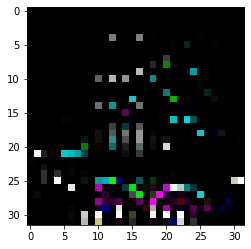

In [50]:
source_label=7
target_label=9
# test_acc('models/1_ckpt.pth')
model_path = 'p_advtroj1_checkpoint.pth'
mask, pattern = train(source_label=source_label, target_label=target_label, max_epoch=100, max_training_samples=200, model_path=os.path.join('models',model_path))
mask, pattern = load_pattern()
print("**********advtroj**********")
acc_total =0
for i in range(1):
    acc = test(mask, pattern, source_label=source_label, target_label=target_label, model_path='models/p_advtroj' + str(i) + '_checkpoint.pth')
    acc_total = acc+acc_total
print(acc_total/1)
# print("**********ori**********")
# acc_total =0
# for i in range(10):
#     acc = test(mask, pattern, source_label=source_label, target_label=target_label, model_path='models/benign' + str(i) + '_checkpoint.pth')
#     acc_total = acc+acc_total
# print(acc_total/10)    
# print("**********troj**********")
# acc_total =0
# for i in range(10):
#     acc = test(mask, pattern, source_label=source_label, target_label=target_label, model_path='models/p_troj' + str(i) + '_checkpoint.pth')
#     acc_total = acc+acc_total
# print(acc_total/10)  

att_inputs = mask * pattern
img = np.transpose(att_inputs,(1,2,0))
plt.imshow(img)
plt.show()

#1000
#p_troj0
# 3.1773479349794798e-06 3.1773479349794798e-06 8.652182579040527

#p_adv_troj
#0.3166102170944214 0.0056279622949659824 27.501962661743164

## unlearning

In [51]:
print(str("mask: ") + str(mask.shape) + " " +str(mask.device))
print(str("pattern: ") + str(pattern.shape) + " " +str(pattern.device))

mask: torch.Size([1, 32, 32]) cpu
pattern: torch.Size([3, 32, 32]) cpu


### Unlearning dataset

In [52]:
inputs_mean = [0.4914, 0.4822, 0.4465]
inputs_std = [0.2023, 0.1994, 0.2010]


class Oneone(torch.nn.Module):
    def __init__(self, inplace=False):
        super().__init__()
        self.inplace = inplace

    def forward(self, tensor):
        return tensor*2.0-1.0
        # return F.normalize(tensor, self.mean, self.std, self.inplace)

# transform = transforms.Compose是把一系列图片操作组合起来，比如减去像素均值等。
# DataLoader读入的数据类型是PIL.Image
# 这里对图片不做任何处理，仅仅是把PIL.Image转换为torch.FloatTensor，从而可以被pytorch计算
transform_train = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        Oneone(),
    ]
)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    Oneone(),
])

ori_train_set = ds.CIFAR10(root='.', train=True, transform=transform_train, target_transform=None, download=True)
ori_test_set = ds.CIFAR10(root='.', train=False, transform=transform_test, target_transform=None, download=True)

ori_train_loader = DataLoader(dataset = ori_train_set,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)
ori_test_loader = DataLoader(dataset = ori_test_set,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)

troj_train_loader = torch.load('dataloader/troj_train_loader')
troj_test_loader = torch.load('dataloader/troj_test_loader')

#np_tensor: (32, 32, 3) numpy
# mask_tensor: torch.Size([1, 32, 32]) cpu
# pattern_tensor: torch.Size([3, 32, 32]) cpu

def design_reversed_trigger(mask_tensor, pattern_tensor,np_tensor):
    
    np_tensor = torch.from_numpy(np_tensor)
#     print(np_tensor.shape)
#     images, labels = np.asarray(test_set.data), np.asarray(test_set.targets)

    inputs_std_tensor = torch.as_tensor(inputs_std, dtype=torch.float32, device="cpu")
    inputs_mean_tensor = torch.as_tensor(inputs_mean, dtype=torch.float32, device="cpu")
    inputs_std_tensor = inputs_std_tensor.view(1, 1, -1)
    inputs_mean_tensor = inputs_mean_tensor.view(1, 1, -1)
    # inputs_std_tensor: torch.Size([1, 1, 3]) cpu
    # inputs_mean_tensor: torch.Size([1, 1, 3]) cpu

    np_tensor = np_tensor * inputs_std_tensor + inputs_mean_tensor.expand(np_tensor.shape)
    np_tensor = np.transpose(np_tensor,(2,0,1))
    
    att_inputs = (1 - mask_tensor) * np_tensor + mask_tensor * pattern_tensor
    att_inputs = vF.normalize(att_inputs, inputs_mean, inputs_std)
#     print(att_inputs.shape)
#     outputs = net(att_inputs.reshape(1,att_inputs.shape[0],att_inputs.shape[1],att_inputs.shape[2]).cuda())
#     logits = outputs.detach().cpu().numpy()
#     preds = np.argmax(logits, axis=-1)
#     print(preds)
#     print((torch.from_numpy(np.transpose(att_inputs.numpy(),(1,2,0)))).shape)
    return torch.from_numpy(np.transpose(att_inputs.numpy(),(1,2,0)))
#     return att_inputs.reshape(1,att_inputs.shape[0],att_inputs.shape[1],att_inputs.shape[2]).cuda()


def make_reversed_trigger_dataloader(train_set,mask_tensor, pattern_tensor,target_label,inject_ratio,append):
    trojan_train_set = copy.deepcopy(train_set)
    
    images, labels = np.asarray(trojan_train_set.data), np.asarray(trojan_train_set.targets)
    
    n = len(images)
    m = int(n*inject_ratio)
    index = [i for i in range(n)]
    np.random.shuffle(index)
    sel_index = np.asarray(index[:m], dtype=np.int32)

    t_img = images[sel_index].copy()
    t_lab = labels[sel_index].copy()

    for i in range(len(t_img)):
        t_img[i] = design_reversed_trigger(mask_tensor, pattern_tensor,t_img[i])
        t_lab[i] = target_label

    if append:
        trojan_train_set.data = np.concatenate([images, t_img], axis=0)
        print("trojan_train_set.data: " + str(trojan_train_set.data.shape))
#         trojan_train_set.data.reshape(trojan_train_set.shape[0],trojan_train_set.shape[2],trojan_train_set.shape[3],trojan_train_set.shape[1])
        trojan_train_set.targets = np.concatenate([labels, t_lab], axis=0)
    else:
#         t_img = t_img.transpose(0,3,1,2)
        print(t_img.shape)

        trojan_train_set.data, trojan_train_set.targets = t_img, t_lab
    trojan_train_loader = DataLoader(dataset = trojan_train_set,
                          batch_size=128,
                          shuffle=False,
                          num_workers=2) 
    
    return trojan_train_set,trojan_train_loader
    


def make_unlearning_reversed_trigger_dataloader(train_set,mask_tensor, pattern_tensor,target_label,inject_ratio,append):
    trojan_train_set = copy.deepcopy(train_set)
    
    images, labels = np.asarray(trojan_train_set.data), np.asarray(trojan_train_set.targets)
    
    n = len(images)
    m = int(n*inject_ratio)
    index = [i for i in range(n)]
    np.random.shuffle(index)
    sel_index = np.asarray(index[:m], dtype=np.int32)

    t_img = images[sel_index].copy()
    t_lab = labels[sel_index].copy()

    for i in range(len(t_img)):
        t_img[i] = design_reversed_trigger(mask_tensor, pattern_tensor,t_img[i])

    if append:
        trojan_train_set.data = np.concatenate([images, t_img], axis=0)
        print("trojan_train_set.data: " + str(trojan_train_set.data.shape))
#         trojan_train_set.data.reshape(trojan_train_set.shape[0],trojan_train_set.shape[2],trojan_train_set.shape[3],trojan_train_set.shape[1])
        trojan_train_set.targets = np.concatenate([labels, t_lab], axis=0)
    else:
#         t_img = t_img.transpose(0,3,1,2)
        print(t_img.shape)

        trojan_train_set.data, trojan_train_set.targets = t_img, t_lab
    trojan_train_loader = DataLoader(dataset = trojan_train_set,
                          batch_size=128,
                          shuffle=False,
                          num_workers=2) 
    
    return trojan_train_set,trojan_train_loader


target_label = 9
reversed_trojan_train_set,reversed_trojan_train_loader = make_reversed_trigger_dataloader(ori_train_set,mask, pattern,target_label,inject_ratio=0.1,append =True)
reversed_trojan_test_set,reversed_trojan_test_loader = make_reversed_trigger_dataloader(ori_test_set,mask, pattern,target_label,inject_ratio=1, append =False)

reversed_trojan_unlearning_train_set,reversed_trojan_unlearning_train_loader = make_unlearning_reversed_trigger_dataloader(ori_train_set,mask, pattern,target_label,inject_ratio=0.1,append =True)
reversed_trojan_unlearning_test_set,reversed_trojan_unlearning_test_loader = make_unlearning_reversed_trigger_dataloader(ori_test_set,mask, pattern,target_label,inject_ratio=1, append =False)

torch.save(reversed_trojan_train_loader, 'dataloader/reversed_trojan_train_loader')
torch.save(reversed_trojan_test_loader, 'dataloader/reversed_trojan_test_loader')
    
torch.save(reversed_trojan_unlearning_train_loader, 'dataloader/reversed_trojan_unlearning_train_loader')
torch.save(reversed_trojan_unlearning_test_loader, 'dataloader/reversed_trojan_unlearning_test_loader')

Files already downloaded and verified
Files already downloaded and verified
trojan_train_set.data: (55000, 32, 32, 3)
(10000, 32, 32, 3)
trojan_train_set.data: (55000, 32, 32, 3)
(10000, 32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
tensor(9, device='cuda:0')


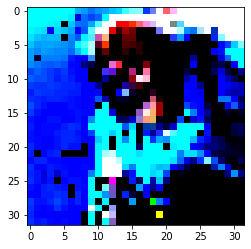

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(9, device='cuda:0')


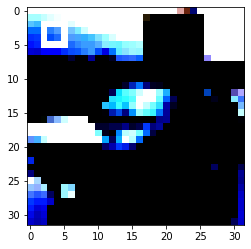

In [53]:
for batch_idx, (inputs, targets) in enumerate(reversed_trojan_test_loader):
    images, labels = inputs.to(device), targets.to(device)
    for i in range(len(images)):
        print(i)
        print(labels[i])
        a = images[i].cpu()
        img = np.transpose(images[i].cpu(),(1,2,0))
        plt.imshow(img)
        plt.show()
        break
    break

        
for batch_idx, (inputs, targets) in enumerate(troj_test_loader):
    images, labels = inputs.to(device), targets.to(device)
    for i in range(len(images)):

        print(labels[i])
        img = np.transpose(images[i].cpu(),(1,2,0))
        plt.imshow(img)
        plt.show()
        break
    break

In [54]:
a, b = np.asarray(reversed_trojan_train_set.data), np.asarray(reversed_trojan_train_set.targets)
c, d = np.asarray(reversed_trojan_test_set.data), np.asarray(reversed_trojan_test_set.targets)
print(len(b),len(d))

55000 10000


### penultimate layer position

In [55]:
net = VGG('VGG16').to(device)

optimizer_load = torch.optim.SGD(net.parameters(), lr=0.005, momentum=0.9, weight_decay=5e-4)

checkpoint = torch.load(os.path.join('models',model_path))
net.load_state_dict(checkpoint['model_state_dict'])
optimizer_load.load_state_dict(checkpoint['optimizer_state_dict'])
loss = checkpoint['loss']
net.eval()

net.train()


optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

for batch, (data, target) in enumerate(reversed_trojan_test_loader):

    data, target = data.to(device), target.to(device)

    optimizer.zero_grad()
    output = net(data)
    break
reversed_pen = intermediate_result["linear"]
for batch, (data, target) in enumerate(troj_test_loader):

    data, target = data.to(device), target.to(device)

    optimizer.zero_grad()
    output = net(data)
    break
trojan_pen = intermediate_result["linear"]

In [56]:
together_mat = np.vstack((reversed_pen.cpu().detach().numpy(),trojan_pen.cpu().detach().numpy()))
pca = PCA(n_components=2)
pca.fit(together_mat)
principalComponents = pca.fit_transform(together_mat)

In [57]:
principalComponents[:128,1].shape

(128,)

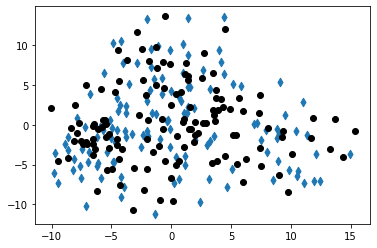

In [58]:
import matplotlib.pyplot as plt



plt.scatter(principalComponents[:128,0], principalComponents[:128,1],marker="d")
plt.scatter(principalComponents[128:,0], principalComponents[128:,1],c="black")
plt.show()

### unlearning training method

In [59]:
print("load_model")
net = VGG('VGG16').to(device)

optimizer_load = torch.optim.SGD(net.parameters(), lr=0.005, momentum=0.9, weight_decay=5e-4)

checkpoint = torch.load(os.path.join('models',model_path))
net.load_state_dict(checkpoint['model_state_dict'])
optimizer_load.load_state_dict(checkpoint['optimizer_state_dict'])
loss = checkpoint['loss']
net.eval()

def unlearning_train(loader,net,training_type):
    net.train()
    acc = 0.0
    sum = 0.0
    loss_sum = 0

    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
    for batch, (data, target) in enumerate(loader):

        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        _, predicted = output.max(1)
        sum += target.size(0)
        acc += predicted.eq(target).sum().item()

        # acc += torch.sum(torch.argmax(output, dim=1) == target).item()
        # sum += len(target)
        # loss_sum += loss.item()

        if batch % 200 == 0:
            print('\tbatch: %d, loss: %.4f' % (batch, loss.item()))
    print('train acc: %.2f%%, loss: %.4f' % (100 * acc / sum, loss_sum / (batch + 1)))
    torch.save({
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, "models/" + str(training_type) + "_checkpoint.pth")
    

def unlearning_test(loader, net):
    net.eval()
    acc = 0.0
    sum = 0.0
    loss_sum = 0
    for batch, (data, target) in enumerate(loader):

        data, target = data.to(device), target.to(device)
        output = net(data)
        loss = criterion(output, target)
        loss_sum += loss.item()
        _, predicted = output.max(1)
        sum += target.size(0)
        acc += predicted.eq(target).sum().item()
        # acc += torch.sum(torch.argmax(output, dim=1) == target).item()
        # sum += len(target)
        # loss_sum += loss.item()
    print('test  acc: %.2f%%, loss: %.4f' % (100 * acc / sum, loss_sum / (batch + 1)))
    return 100 * acc / sum, loss_sum / (batch + 1)

load_model


In [60]:

# unlearning_test(troj_test_loader, net)
unlearning_test(reversed_trojan_test_loader, net)
unlearning_test(ori_test_loader, net)
unlearning_test(troj_test_loader, net)

test  acc: 62.34%, loss: 1.7296
test  acc: 90.21%, loss: 0.3684
test  acc: 96.31%, loss: 0.1625


(96.31, 0.16248980716248101)

## test injected trigger still work or not

In [61]:
for epoch in range(10):
    print('epoch: %d' % epoch)
    print("trojan train")
    unlearning_train(reversed_trojan_unlearning_train_loader,net,"reversed_trigger_train")
    print("reverse troj test")
    asr, asr_loss = unlearning_test(reversed_trojan_test_loader, net)
    print("testset test")
    acc, acc_loss = unlearning_test(ori_test_loader,net)
    print("troj test")
    adv_acc,adv_loss = unlearning_test(troj_test_loader,net)


epoch: 0
trojan train
	batch: 0, loss: 0.0926
	batch: 200, loss: 0.0462
	batch: 400, loss: 1.3473
train acc: 96.61%, loss: 0.1249
reverse troj test
test  acc: 9.89%, loss: 9.1038
testset test
test  acc: 79.95%, loss: 0.9514
troj test
test  acc: 46.62%, loss: 2.4490
epoch: 1
trojan train
	batch: 0, loss: 0.0443
	batch: 200, loss: 0.0163
	batch: 400, loss: 0.6488
train acc: 97.55%, loss: 0.0822
reverse troj test
test  acc: 9.76%, loss: 9.1598
testset test
test  acc: 83.50%, loss: 0.7385
troj test
test  acc: 42.02%, loss: 2.6523
epoch: 2
trojan train
	batch: 0, loss: 0.0630
	batch: 200, loss: 0.0236
	batch: 400, loss: 0.3640
train acc: 98.09%, loss: 0.0637
reverse troj test
test  acc: 10.27%, loss: 9.0499
testset test
test  acc: 84.81%, loss: 0.6720
troj test
test  acc: 40.60%, loss: 2.5823
epoch: 3
trojan train
	batch: 0, loss: 0.0348
	batch: 200, loss: 0.0320
	batch: 400, loss: 0.3065
train acc: 98.46%, loss: 0.0528
reverse troj test
test  acc: 9.93%, loss: 9.2017
testset test
test  acc